In [1]:
import os
import csv
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import argparse
import ntpath
import sys
import tensorflow as tf
import numpy as np
import datetime
from prettytable import PrettyTable
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from preprocessing import is_number

In [3]:
path = '/home/wanli/data/Extended_ctr/citeulike_a_extended/paper_info.csv'
path = '/home/wanli/data/Extended_ctr/citeulike_a_extended/papers_info_corrected_pages_years.csv'
null_token = 'NaN'
now = datetime.datetime.now()
    
clean_file_path = path +'.cleaned'


# Month converter
months = ['apr','aug', 'dec','feb', 'jan' ,'jul' ,'jun' ,'mar' ,'may', 'nov', 'oct', 'sep']
month_convert_func = lambda x: x if x in months else null_token

def number_convert_func (x):
    if x == '-1':
        return null_token
    if is_number(x):
        if x == 'NaN':
            return null_token
        x = float(x)
        x = int(x)
        return x
    return null_token

def year_convert_func (x):
    if is_number(x):
        if x == 'NaN':
            return null_token
        x = float(x)
        x = int(x)
        if x < 1000:
            return null_token
        return now.year - x
    else:
        return null_token

labels = ['doc_id', 'citeulike_id', 'type', 'pages', 'year']
labels_dtype = {'doc_id': np.int32, 'citeulike_id': np.int32, 'type': str, 'pages': np.int32}
convert_func= {'pages': number_convert_func, 'doc_id': number_convert_func, 'year': year_convert_func,
               'citeulike_id': number_convert_func}
# labels = ['doc_id', 'citeulike_id', 'type', 'journal', 'booktitle', 'series', 'pages', 'year', 'month', 'address']
# labels_dtype = {'doc_id': np.int32, 'citeulike_id': np.int32, 'type': str, 'journal': str, 'booktitle': str,
#                 'series': str,
#                 'pages': np.int32, 'month': str, 'address': str}
# convert_func = {'month': month_convert_func, 'pages': number_convert_func, 'doc_id': number_convert_func,
#                 'citeulike_id': number_convert_func}

df = pd.read_table(clean_file_path, delimiter='\t', index_col = 'doc_id', usecols=labels,dtype=labels_dtype,
                     na_values='\\N',na_filter=False,
                     converters=convert_func)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: ParserWarning: Both a converter and dtype were specified for column doc_id - only the converter will be used
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: ParserWarning: Both a converter and dtype were specified for column citeulike_id - only the converter will be used
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: ParserWarning: Both a converter and dtype were specified for column pages - only the converter will be used


In [4]:
print(df.shape)
# count of unique values:
print (df.apply(pd.Series.nunique))

(16981, 4)
citeulike_id    16962
type               15
pages             129
year               85
dtype: int64


In [5]:
#Filter values with frequency less than min_freq
def filter(df, tofilter_list, min_freq):
    for col in tofilter_list:
        to_keep =  df[col].value_counts().reset_index(name="count").query("count > %d" %min_freq)["index"]
        to_keep = to_keep.values.tolist()
        df[col] = [x if x in to_keep else 'NaN' for x in df[col] ]
    return df

tofilter_list = []
df = filter(df,tofilter_list,2)
print(df.shape)
print (df.apply(pd.Series.nunique))

# 
# # Convert catigorical feature into one-hot encoding
# def dummmy_df(df, todummy_list):
#     for x in todummy_list:
#         dummies = pd.get_dummies(df[x], prefix=x, dummy_na=True)
#         df = df.drop(x,1)
#         df = pd.concat([df,dummies], axis=1)
#     return df

# todummy_list = ['type']
# df_dummy = dummmy_df(df,todummy_list)
# # print(df_dummy.head(2))
# # print (df2)
# print('----------------------------')
# # print (df_dummy['journal'].value_counts())
# # .reset_index(name="count").query("count > 3")["index"]
# print('----------------------------')
# print(df_dummy.shape)
# print (df_dummy.apply(pd.Series.nunique))

(16981, 4)
citeulike_id    16962
type               15
pages             129
year               85
dtype: int64


In [6]:
print (df.pages.unique())
print (df.pages.value_counts())

['NaN' 4 5 8 7 12 2 3 28 10 17 9 42 203 14 11 6 20 19 18 16 56 13 29 41 39
 15 40 22 31 25 23 59 27 48 33 35 34 51 30 60 43 32 24 83 1 21 70 37 46 62
 53 45 26 36 38 47 44 50 74 57 49 573 -187 -191 -297 90 54 52 63 -64 55 97
 65 77 -33 85 261 58 66 108 71 -194 75 68 88 93 73 117 92 78 64 152 61 133
 -398 -3 -51 5992 -2 3643 132 -23 87 -22 76 104 -437 -14 89 143 144 -155
 1575 1836 103 72 -1 395 134 124 553 -140 -15 129 69 1694 -93 3808]
NaN     5649
5       1035
7       1008
9        946
4        781
3        773
6        763
11       666
8        645
10       546
12       419
13       360
2        315
14       310
15       240
1        227
16       196
17       180
19       139
18       138
20       130
21       119
22       106
24        88
23        83
25        70
27        70
29        69
30        68
26        64
        ... 
-22        1
-64        1
-23        1
-51        1
1575       1
63         1
553        1
395        1
69         1
71         1
72         1
73         1


['NaN' 4 5 ..., 8 'NaN' 3]
(array([-10,  -5,  -3,  -2,  -1,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  80]), array([  16, 5649,    1,    2,    1,  227,  315,  773,  781, 1035,  763,
       1008,  645,  946,  546,  666,  419,  360,  310,  240,  196,  180,
        138,  139,  130,  119,  106,   83,   88,   70,   64,   70,   53,
         69,   68,   42,   39,   53,   49,   52,   37,   33,   21,   35,
         21,   22,   19,   20,   12,   21,   17,   13,   15,   12,   13,
         13,    7,   10,    6,    7,   10,    7,    4,    8,    9,    3,
          4,    1,    3,    3,    3,    2,    1,    4,    1,    1,  

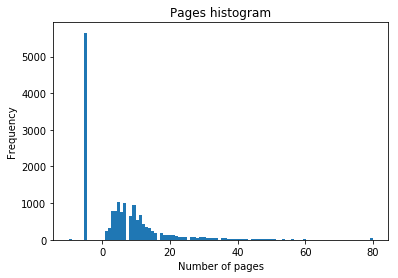

In [7]:
pages = df.pages.values
print(pages)
pages=np.asarray(pages)


pages[pages == 'NaN'] = -5
pages=pages.astype(int)

pages[pages < -10] = -10
pages[pages > 80] = 80
fig = plt.figure()
n, bins, patches = plt.hist(pages,bins=100)
print(np.unique(pages,return_counts=True))

print(bins)
# l = plt.plot(bins)
# fig = pages.plot.hist(y=idx).get_figure()
plt.title("Pages histogram")
plt.xlabel("Number of pages")
plt.ylabel("Frequency")
plt.savefig('pages_hist.eps', format='eps', dpi=1000)
plt.show()

In [7]:
print (df.year.unique())
print (df.year.value_counts())

['NaN' '2004' '2002' '2001' '2000' '2003' '1998' '1999' '-1' '2005' '1993'
 '1994' '1962' '2006' '1997' '1996' '1992' '1986' '1988' '1995' '1991'
 '1985' '2007' '1990' '1989' '1987' '1976' '1978' '1982' '1950' '1961'
 '1979' '1972' '1974' '1973' '1981' '1970' '1965' '1968' '1975' '1983'
 '1984' '1980' '1971' '1957' '1960' '1948' '1977' '1912' '1929' '1952'
 '1969' '1956' '1967' '1949' '2009' '1946' '1936' '1966' '1964' '1941'
 '1958' '2013' '1959' '1935' '2014' '2015' '2010' '1953' '1963' '1943'
 '1951' '1871' '1947' '1954' '2011' '2008' '1944' '1955' '2016' '1899'
 '20060100' '1896' '3' '0' '1940' '1893' '2012']
2007        1562
2005        1542
2008        1523
2006        1505
2009        1341
2004        1315
2003        1039
2002         927
2001         803
2010         701
2000         691
-1           634
1999         539
1998         450
1997         321
1996         283
1995         228
1994         193
1993         153
1992         127
1991         111
1990         108
1989 

[ 1850.    1851.75  1853.5   1855.25  1857.    1858.75  1860.5   1862.25
  1864.    1865.75  1867.5   1869.25  1871.    1872.75  1874.5   1876.25
  1878.    1879.75  1881.5   1883.25  1885.    1886.75  1888.5   1890.25
  1892.    1893.75  1895.5   1897.25  1899.    1900.75  1902.5   1904.25
  1906.    1907.75  1909.5   1911.25  1913.    1914.75  1916.5   1918.25
  1920.    1921.75  1923.5   1925.25  1927.    1928.75  1930.5   1932.25
  1934.    1935.75  1937.5   1939.25  1941.    1942.75  1944.5   1946.25
  1948.    1949.75  1951.5   1953.25  1955.    1956.75  1958.5   1960.25
  1962.    1963.75  1965.5   1967.25  1969.    1970.75  1972.5   1974.25
  1976.    1977.75  1979.5   1981.25  1983.    1984.75  1986.5   1988.25
  1990.    1991.75  1993.5   1995.25  1997.    1998.75  2000.5   2002.25
  2004.    2005.75  2007.5   2009.25  2011.    2012.75  2014.5   2016.25
  2018.    2019.75  2021.5   2023.25  2025.  ]


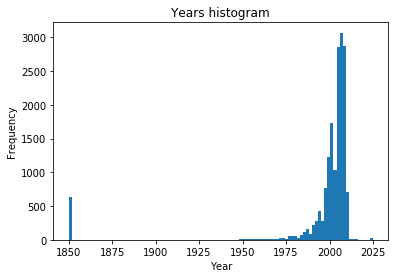

In [10]:
year = df.year.values
year=np.asarray(year)
year[year == 'NaN'] = 2025
# counts_nan = np.count_nonzero(np.isnan(year.astype(float)))
# print(counts_nan)
year=year.astype(int)
year[year < 1850] = 1850
year[(year > 2017) & (year != 2025)] = 2020
fig = plt.figure()
n, bins, patches = plt.hist(year,bins=100)
print(bins)
# l = plt.plot(bins)

# fig = pages.plot.hist(y=idx).get_figure()
plt.title("Years histogram")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.savefig('year_hist.eps', format='eps', dpi=1000)
plt.show()

In [18]:
ye2 = df.year.values
print(ye2)
ye2=np.asarray(ye2)
ye2[ye2 == 'NaN'] = -10
print(len(ye2[ye2 == -10]))

[-10 '2004' '2002' ..., '2011' '2010' '2011']
20


In [6]:
print (df.type.value_counts())

article          12202
inproceedings     2088
book              1490
misc               396
electronic         207
proceedings        169
techreport         160
incollection       124
inbook              54
unpublished         36
phdthesis           25
NaN                 20
mastersthesis        7
manual               2
booklet              1
Name: type, dtype: int64


In [5]:
print(df_dummy.shape)
df_dummy.dropna(inplace=True)
print(df_dummy.shape)
print (df_dummy.apply(pd.Series.nunique))

(16981, 19)
(16981, 19)
citeulike_id          16962
pages                   263
year                     88
type_NaN                  2
type_article              2
type_book                 2
type_booklet              2
type_electronic           2
type_inbook               2
type_incollection         2
type_inproceedings        2
type_manual               2
type_mastersthesis        2
type_misc                 2
type_phdthesis            2
type_proceedings          2
type_techreport           2
type_unpublished          2
type_nan                  1
dtype: int64


In [4]:
# min-max normalization:
from sklearn import preprocessing

# x = df.loc[:,todummy_list].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df.loc[:,todummy_list] = pandas.DataFrame(x_scaled)

values = df.values
imputer = preprocessing.Imputer()
transformed_values = imputer.fit_transform(values)
# count the number of NaN values in each column
print(np.isnan(transformed_values).sum())

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(transformed_values)
transformed_df= pd.DataFrame(x_scaled)

0


In [5]:
print(transformed_df.shape)
print(x_scaled.shape)
# print(transformed_df.nunique())
# print (transformed_df.head(2))

(25976, 1893)
(25976, 1893)


In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# training= np.random.randint(2, size=(x_scaled.shape[0],x_scaled.shape[1]+1))
# training[:,:-1] = x_scaled

y= np.random.randint(2, size=(x_scaled.shape[1]))
# y= y.reshape((y.shape[0],1))
print(x_scaled.shape)
print(y.shape)

# evaluate an LDA model on the dataset using k-fold cross validation
model = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=3, random_state=7)
result = cross_val_score(model, np.transpose(np.matrix(x_scaled)), np.transpose(y), cv=kfold, scoring='accuracy')
print(result.mean())

(25976, 1893)
(1893,)


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.491811938722


In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import os
from gensim import corpora
import gensim

Using TensorFlow backend.


2017-10-01 22:49:37,599 : INFO : 'pattern' package not found; tag filters are not available for English


In [6]:
fname ='/home/wanli/data/word_embeddings.txt'
model = gensim.models.KeyedVectors.load_word2vec_format(fname, binary=False)

2017-10-01 22:52:16,103 : INFO : loading projection weights from /home/wanli/data/word_embeddings.txt


2017-10-01 22:52:59,142 : INFO : loaded (302775, 200) matrix from /home/wanli/data/word_embeddings.txt


In [7]:
model.wv.similarity('information', 'system')

-0.003150100318443387

In [22]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('sanchez', 0.5267158150672913),
 ('kelleher', 0.5113817453384399),
 ('wrath', 0.5070061683654785),
 ('yoatl', 0.47525104880332947),
 ('girl', 0.4729466438293457),
 ('tollu', 0.47179219126701355),
 ('lich', 0.4713619351387024),
 ('businessman', 0.47063136100769043),
 ('mansion', 0.47035470604896545),
 ('ruth', 0.4694134294986725)]

In [27]:
model.wv.most_similar_cosmul(positive=['computer', 'code'], negative=['biology'])

[('program', 0.9820653200149536),
 ('compiler', 0.9291761517524719),
 ('instructions', 0.9030072689056396),
 ('binaries', 0.9001923203468323),
 ('c/c++', 0.8978627324104309),
 ('applet', 0.8968085050582886),
 ('firmware', 0.891533374786377),
 ('eprom', 0.8878062963485718),
 ('debugger', 0.8845652341842651),
 ('pc', 0.8814089894294739)]

In [35]:
model.wv.most_similar(positive=['recommender'])

[('recommendation', 0.8478092551231384),
 ('recommenders', 0.636306643486023),
 ('personalization', 0.596664309501648),
 ('tagir', 0.5812981724739075),
 ('question-answering', 0.5709900856018066),
 ('e-learning', 0.5520929098129272),
 ('collaborative-filtering', 0.5501213073730469),
 ('tagging', 0.5483794808387756),
 ('personalized', 0.546078085899353),
 ('cbir', 0.5428563952445984)]

In [2]:
import  tensorflow as tf

a = tf.placeholder(tf.float32, shape=[None,3], name="input_placeholder_a")
b = tf.placeholder(tf.float32, shape=[None,3], name="input_placeholder_b")
normalize_a = tf.nn.l2_normalize(a,0)        
normalize_b = tf.nn.l2_normalize(b,0)
cos_similarity = tf.losses.cosine_distance(a,b,dim=1)
sess=tf.Session()
cos_sim=sess.run(cos_similarity,feed_dict={a:[[1,2,3],[1,2,3]],b:[[2,4,6],[2,4,6]]})
print(cos_sim)

-27.0


In [18]:
normalize_a = tf.nn.l2_normalize(a,1)        
normalize_b = tf.nn.l2_normalize(b,1)
x,y=sess.run([normalize_a, normalize_b],feed_dict={a:[[1,2,3],[2,4,6]],b:[[1,2,3],[2,4,6]]})
print()
print(x)
print(y)


[[ 0.26726124  0.53452247  0.80178368]
 [ 0.26726124  0.53452247  0.80178368]]
[[ 0.26726124  0.53452247  0.80178368]
 [ 0.26726124  0.53452247  0.80178368]]


In [19]:
cos_similarity = tf.losses.cosine_distance(normalize_a,normalize_b, reduction=tf.losses.Reduction.NONE,
                                           dim=1)
cos_sim=sess.run(cos_similarity,feed_dict={a:[[1,2,3],[2,4,6]],b:[[1,2,3],[2,4,6]]})
print(1-cos_sim)

[[ 0.99999988]
 [ 0.99999988]]


In [17]:
radial_diffs = tf.multiply(normalize_a, normalize_b)
print(sess.run(radial_diffs,feed_dict={a:[[1,2,3],[2,4,6]],b:[[1,2,3],[2,4,6]]}))
losses = 1 - tf.reduce_sum(radial_diffs, axis=(1,), keep_dims=True)
print(sess.run(losses,feed_dict={a:[[1,2,3],[2,4,6]],b:[[1,2,3],[2,4,6]]}))

[[ 0.19999999  0.19999999  0.19999999]
 [ 0.79999995  0.79999995  0.79999995]]
[[ 0.40000004]
 [-1.39999986]]


In [51]:
import tensorflow as tf
import numpy as np

sess = tf.InteractiveSession()

# a = tf.placeholder(tf.int32, shape =[None],name='labels')
# b = tf.placeholder(tf.float32, shape = [None,1],name='logits')
labels = tf.placeholder(tf.int32, shape =[None],name='labels2')
output = tf.placeholder(tf.float32, shape =[None,None],name='output2')
sess.run(tf.global_variables_initializer())
# feed_dict={b:np.array([[0.1],[0.8],[0.1],[0.5]]), a:np.array([0.9,0,0,0])}

# c = tf.nn.sparse_softmax_cross_entropy_with_logits(
#     logits=b, labels=a
# ).eval(feed_dict)
# print (c)
# d = tf.losses.sparse_softmax_cross_entropy(labels=a,logits=b,reduction=tf.losses.Reduction.NONE).eval(feed_dict)
# print(d)




output1=np.array([[0.3,0.3,0.4],[0.3 , 0.4  ,0.3 ],[0.1 , 0.2 , 0.7]])
output2=np.array([[0.1,0.2,0.7],[0.1 , 0.7  ,0.2 ],[0.3 , 0.4 , 0.3]])
output3=np.array([[0.2,0.4,1.4],[0.2 , 1.4  ,0.4 ],[0.6 , 0.8 , 0.6]])
output4=np.array([[0.2,0.4],[0.2 , 1.4 ],[0.6 , 0.8 ]])
output4=np.array([[0.2,0.8],[0.2 , 0.8 ],[0.6 , 0.4 ]])
output5=np.array([[0.2],[0.8 ],[ 0.4 ]])



label= np.array([1,1,-1])

print('--------------------------')
print(tf.maximum(tf.cast(label,tf.float32),0.1).eval())
print('--------------------------')
oh_label=tf.one_hot(labels,2)
weights=[2,2,2]
print(oh_label.eval({labels:label}))
# feed = {labels:label,output: output5}
# ce =tf.losses.softmax_cross_entropy(
#     logits=output, onehot_labels=oh_label,weights=weights
# ).eval(feed)
# print(ce)
# print(tf.reduce_mean(ce).eval())


# label2= np.array([1,1,0])
feed = {labels:label,output: output5}
ce_spars= tf.losses.sparse_softmax_cross_entropy(logits=output, labels=labels,weights=weights
).eval(feed)
print(ce_spars)
print('--------------------------')
feed = {labels:label,output: output5}
sm_output=tf.nn.softmax(output,dim=1)
print(sm_output.eval(feed))

# 
# ce_sm=-tf.reduce_sum(tf.cast(oh_label,tf.float32)* tf.log(sm_output), reduction_indices=[1]).eval(feed)
# print(ce_sm)
# print(tf.reduce_mean(ce_sm).eval())

# cross_entropy = -tf.reduce_sum(label1 * tf.log(output3), reduction_indices=[1]).eval()
# print(cross_entropy)
# print(tf.reduce_mean(cross_entropy).eval())
# prediction = tf.sigmoid(d).eval(feed_dict)
# print(prediction)
# predicted_class = tf.greater(prediction,0.5)
# correct = tf.equal(predicted_class, tf.equal(a,1))
# accuracy = tf.reduce_mean( tf.cast(correct, 'float') )
# print(accuracy.eval(feed_dict))

--------------------------
[ 1.   1.   0.1]
--------------------------


[[ 0.  1.]
 [ 0.  1.]
 [ 0.  0.]]


InvalidArgumentError: Received a label value of -1 which is outside the valid range of [0, 1).  Label values: 1 1 -1
	 [[Node: sparse_softmax_cross_entropy_loss_20/xentropy/xentropy = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_output2_44_0_1, _arg_labels2_44_0_0)]]

Caused by op 'sparse_softmax_cross_entropy_loss_20/xentropy/xentropy', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-74ea13779171>", line 50, in <module>
    ce_spars= tf.losses.sparse_softmax_cross_entropy(logits=output, labels=labels,weights=weights
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/losses/losses_impl.py", line 742, in sparse_softmax_cross_entropy
    name="xentropy")
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 1693, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 2491, in _sparse_softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of -1 which is outside the valid range of [0, 1).  Label values: 1 1 -1
	 [[Node: sparse_softmax_cross_entropy_loss_20/xentropy/xentropy = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_output2_44_0_1, _arg_labels2_44_0_0)]]


In [8]:
import tensorflow as tf
from random import randint
import numpy as np 

epsilon = 1e-8
dims = [3,1]
pos  = [1,0,1]
tf.set_random_seed(42)
# logits = tf.random_uniform(dims, maxval=1, dtype=tf.float32)
logits = np.array([0.5, 0.6 ,0.8])
# logits_2D = np.array([[ 0.94080913 , 0.05919087],
#  [ 0.77504122 , 0.22495878],
#  [ 0.74438941 , 0.25561059]])
logits_2D = tf.stack([logits,tf.subtract(1.0,logits)],axis=1)+epsilon
softmax_logits_2D = tf.nn.softmax(logits_2D,dim=0)
ohe_labels = tf.one_hot(pos, 2)
labels=tf.constant(pos)
labels_2d=tf.stack([labels,tf.subtract(1,labels)], axis=1)
# res1 = tf.nn.softmax_cross_entropy_with_logits(labels=ohe_labels,logits=logits_2D)

# res2 = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_2D, labels=classes)

res3 = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_2D, labels=labels)

res4 = -tf.reduce_sum(tf.to_float(labels_2d)*tf.log(softmax_logits_2D),reduction_indices=[1])

# loss_fn =loss(logits_2D,labels_2d)
with tf.name_scope('loss'):
    logits = tf.reshape(logits_2D, (-1, 2))
    shape = [logits.get_shape()[0], 2]
    logits = logits + epsilon
    labels = tf.to_float(tf.reshape(labels_2d, (-1, 2)))

    softmax = tf.nn.softmax(logits)
    cross_entropy = -tf.reduce_sum(labels * tf.log(softmax),
                                   reduction_indices=[1])

    cross_entropy_mean = tf.reduce_mean(cross_entropy,
                                        name='xentropy_mean')
    tf.add_to_collection('losses', cross_entropy_mean)

    loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
with tf.Session() as sess:
    a,b,lab,logi,sm_log,softm,ce = sess.run([ res3,res4,labels,logits_2D,softmax_logits_2D,softmax,cross_entropy])
    
    print (a, b)
    print(tf.reduce_mean(a).eval(),tf.reduce_mean(b).eval())
    print('logits:\n',logi)
    print('softmax logits:\n',sm_log)
    print('softmax 2:\n',softm)
    print('Cross_entropy',ce)
    # print('labels:\n',lab)
    # print('Loss\n',loss_1)
    
    print (a == b)

[ 0.69314718  0.59813881  1.03748798] [ 1.23983097  1.07291901  0.93983102]
0.776258 1.08419
logits:
 [[ 0.5         0.5       ]
 [ 0.60000002  0.39999998]
 [ 0.80000001  0.2       ]]
softmax logits:
 [[ 0.28943312  0.37797815]
 [ 0.31987306  0.34200874]
 [ 0.39069384  0.28001308]]
softmax 2:
 [[ 0.5         0.5       ]
 [ 0.54983401  0.45016599]
 [ 0.64565629  0.35434368]]
Cross_entropy [ 0.69314718  0.79813892  0.43748799]
[False False False]


In [3]:
def loss(logits, labels):
    """Calculates the loss from the logits and the labels.

    Args:
      logits: Logits tensor, float - [batch_size, 2].
      labels: Labels tensor, int32 - [batch_size, 2].

    Returns:
      loss: Loss tensor of type float.
    """
    with tf.name_scope('loss'):
        logits = tf.reshape(logits, (-1, 2))
        shape = [logits.get_shape()[0], 2]
        epsilon = tf.constant(value=1e-8, shape=shape)
        logits = logits + epsilon
        labels = tf.to_float(tf.reshape(labels, (-1, 2)))

        softmax = tf.nn.softmax(logits)
        cross_entropy = -tf.reduce_sum(labels * tf.log(softmax),
                                       reduction_indices=[1])

        cross_entropy_mean = tf.reduce_mean(cross_entropy,
                                            name='xentropy_mean')
        tf.add_to_collection('losses', cross_entropy_mean)

        loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
    return loss

In [15]:
# Import required modules
import pandas as pd
from sklearn import preprocessing
import numpy as np
# Set charts to view inline
%matplotlib inline
# Create an example dataframe with a column of unnormalized data
data = {'score': [234,24,14,27,np.nan,46,73,np.nan,59,160], 
        'b': [1988,1980,1999,2004,2014,np.nan,2016,np.nan,1885,1850]}#,'a': [1,0,1,0,1,1,0,1,0,1],}
df = pd.DataFrame(data)
df

,b,score
0,1988.0,234.0
1,1980.0,24.0
2,1999.0,14.0
3,2004.0,27.0
4,2014.0,NaN
5,NaN,46.0
6,2016.0,73.0
7,NaN,NaN
8,1885.0,59.0
9,1850.0,160.0


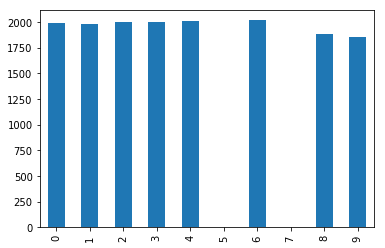

In [16]:
# View the unnormalized data
df.b.plot(kind='bar')

,0,1
0,0.986118,1.000000
1,0.982152,0.106383
2,0.991572,0.063830
3,0.994051,0.119149
4,0.999008,0.000000
5,0.000000,0.200000
6,1.000000,0.314894
7,0.000000,0.000000
8,0.935052,0.255319
9,0.917700,0.685106


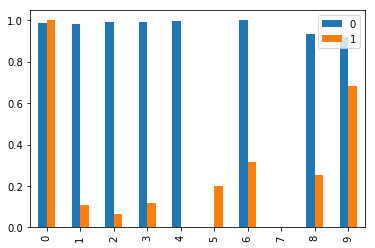

In [10]:
x = df.values.astype(float)
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

df_normalized.plot(kind='bar')
# View the dataframe
df_normalized

In [17]:
values = df.values
imputer = preprocessing.Imputer()
transformed_values = imputer.fit_transform(values)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(transformed_values)
transformed_df= pd.DataFrame(x_scaled)

transformed_df

,0,1
0,0.831325,1.000000
1,0.783133,0.045455
2,0.897590,0.000000
3,0.927711,0.059091
4,0.987952,0.298295
5,0.704819,0.145455
6,1.000000,0.268182
7,0.704819,0.298295
8,0.210843,0.204545
9,0.000000,0.663636


In [2]:
import numpy as np
def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    print(dcg_max)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [4]:
r = [1, 2, 3, 0, 0, 1, 2, 2, 3, 0]
r = [[1,1],[1,1],[1,0]]
print(np.mean([ndcg_at_k(x,2,1) for x in r]))

1.63092975357
1.63092975357
1.0
1.0


In [7]:
a = [1]*20

In [32]:
import pandas as pd

path='/home/wanli/data/Extended_ctr/citeulike_a_extended/item-tag.dat'
df = pd.read_csv(path, delimiter='|', names=['a'])
df = df.a.str.split(' ', n=1, expand=True,)
print(df)
# df.sort_values(['0','1'], ascending=[True,True])
print(df[0].astype(int).sort_values(ascending=False))

         0                                                  1
0       17  4276 32443 37837 3378 7650 44590 42810 28819 4...
1       48  40070 39891 9827 39406 45156 20392 18317 19332...
2       66  35531 33478 46208 24430 13634 30698 31407 2230...
3       54  2383 36288 43395 41495 9102 35490 1858 20309 2...
4       30  30816 24430 40491 32766 20309 1223 30698 23613...
5       36  14321 17329 20475 26937 17186 38235 38276 3069...
6       21  5958 35646 37837 1535 29796 10457 20407 12347 ...
7       28  7569 13421 28760 30180 23430 31867 39861 2120 ...
8       39  40117 43055 36288 37682 24827 5851 33535 28329...
9       12  28623 39682 29430 18187 44590 44986 38780 2300...
10      37  7569 1934 28795 3687 20309 21006 19517 30698 2...
11      32  11122 41063 3687 19229 44181 21006 10212 30698...
12       7          12298 34605 37837 14977 41703 20629 30698
13       6                37837 11423 20295 25507 30698 35133
14       7             6403 6510 33816 28819 2120 45056 30698
15      

In [1]:
import tensorflow as tf
import numpy as np 

a = tf.constant(np.arange(1, 13, dtype=np.float32),
                shape=[2, 6])
b = tf.constant(np.arange(1, 13, dtype=np.float32),
                shape=[2, 3,6])
aa = tf.reshape(a,[tf.shape(a)[0],1,tf.shape(a)[1]])
sess = tf.InteractiveSession()

[[  1.   2.   3.   4.   5.   6.]
 [  7.   8.   9.  10.  11.  12.]] 
====
 [[[  1.   2.   3.   4.   5.   6.]
  [  7.   8.   9.  10.  11.  12.]
  [ 12.  12.  12.  12.  12.  12.]]

 [[ 12.  12.  12.  12.  12.  12.]
  [ 12.  12.  12.  12.  12.  12.]
  [ 12.  12.  12.  12.  12.  12.]]] 
====
 [[[  91.  217.]
  [ 217.  559.]
  [ 252.  684.]]

 [[ 252.  684.]
  [ 252.  684.]
  [ 252.  684.]]] [2 3 2]


In [21]:
c = tf.tensordot(b,a,axes=[[2],[1]])
print(a.eval(),'\n====\n',b.eval(),'\n====\n',c.eval(), tf.shape(c).eval())

[[  1.   2.   3.   4.   5.   6.]
 [  7.   8.   9.  10.  11.  12.]] 
====
 [[[  1.   2.   3.   4.   5.   6.]
  [  7.   8.   9.  10.  11.  12.]
  [ 12.  12.  12.  12.  12.  12.]]

 [[ 12.  12.  12.  12.  12.  12.]
  [ 12.  12.  12.  12.  12.  12.]
  [ 12.  12.  12.  12.  12.  12.]]] 
====
 [[[  91.  217.]
  [ 217.  559.]
  [ 252.  684.]]

 [[ 252.  684.]
  [ 252.  684.]
  [ 252.  684.]]] [2 3 2]


In [4]:
print(np.dot([  1. ,  2.,   3. ,  4.  , 5.,   6.], [  1. ,  2.,   3. ,  4.  , 5.,   6.]))
print(np.dot([  1. ,  2.,   3. ,  4.  , 5.,   6.], [  7. ,  8.,   9.  ,10.  ,11. , 12.]))
print(np.dot([  1. ,  2.,   3. ,  4.  , 5.,   6.], [12.,  12.,  12.,  12.,  12.,  12.]))

91.0
217.0
252.0


In [5]:
print(np.dot([   7.  , 8. ,  9. , 10.,  11. , 12.], [12.,  12.,  12.,  12.,  12.,  12.]))

684.0


In [22]:
d = tf.einsum('aij,aj->ai',b, a)  # out[a,i,k] = sum_j s[a,i,j] * t[a, j, k])
print(aa.eval(),'\n====\n',b.eval(),'\n====\n',d.eval(), tf.shape(d).eval())

[[[  1.   2.   3.   4.   5.   6.]]

 [[  7.   8.   9.  10.  11.  12.]]] 
====
 [[[  1.   2.   3.   4.   5.   6.]
  [  7.   8.   9.  10.  11.  12.]
  [ 12.  12.  12.  12.  12.  12.]]

 [[ 12.  12.  12.  12.  12.  12.]
  [ 12.  12.  12.  12.  12.  12.]
  [ 12.  12.  12.  12.  12.  12.]]] 
====
 [[  91.  217.  252.]
 [ 684.  684.  684.]] [2 3]


In [2]:
import tensorflow as tf
import numpy as np

example = tf.SparseTensor(indices=[[0], [1], [2]], values=[3, 6, 9], dense_shape=[3])

vocabulary_size = 10
embedding_size = 1
var = np.array([0.0, 1.0, 4.0, 9.0, 16.0, 25.0, 36.0, 49.0, 64.0, 81.0])
embeddings = tf.Variable(var)

embed = tf.nn.embedding_lookup_sparse(embeddings, example, None)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(sess.run(embed)) # prints [  9.  36.  81.]

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[  9.  36.  81.]


In [1]:
import tensorflow as tf
import numpy as np 
k = 6
m = 4
tags = 3, [[0,0],[1,1],[2,2],[2,0]]
batch_size = 4
idx = tf.constant(np.arange(batch_size, dtype=np.int64),
                shape=[ batch_size,1])
print(idx)
v_idx = tf.constant([0,2,0,1])

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
print(idx.eval())
print(v_idx.eval())

Tensor("Const:0", shape=(4, 1), dtype=int64)
[[0]
 [1]
 [2]
 [3]]
[0 2 0 1]


In [6]:
# tags_sparse = tf.SparseTensor(indices=tags[1], values=tf.ones(len(tags[1])), dense_shape=(m, tags[0]))
tags_actual = tf.SparseTensor(idx,v_idx,dense_shape=[batch_size])
# embedding_var = tf.get_variable(name="embedding", shape=[tags[0], k])
# embedding_var = tf.get_variable(name="embedding", shape=[tags[0], k])
# tags_matrix = tf.constant(np.random.randint(0,2,size=(5,10)),dtype=tf.float32)
tags_matrix = tf.SparseTensor([[0,0],[0,1],[1,3],[2,0],[2,1]],values=tf.ones([5]),dense_shape=[5,10])

print(tags_matrix.eval())
tags_embeddings = tf.nn.embedding_lookup_sparse(tags_matrix, tags_actual,None)
sess.run(tf.global_variables_initializer())
print(tags_actual.eval())
# print(embedding_var.eval())
print(sess.run(tags_embeddings)) # prints [  9.  36.  81.]

SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 3],
       [2, 0],
       [2, 1]]), values=array([ 1.,  1.,  1.,  1.,  1.], dtype=float32), dense_shape=array([ 5, 10]))


TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("SparseTensor_6/indices:0", shape=(5, 2), dtype=int64), values=Tensor("ones_2:0", shape=(5,), dtype=float32), dense_shape=Tensor("SparseTensor_6/dense_shape:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.

In [10]:
tags_matrix = tf.SparseTensor([[0,0],[0,1],[1,0],[2,0],[2,1]],values=tf.ones([5]),dense_shape=[3,2])
prediction = tf.constant(np.random.randint(0,3,size=(3,2)),dtype=tf.float32)
print(prediction.eval())
print(tags_matrix.eval())
print(tf.sparse_tensor_to_dense(tags_matrix).eval())

[[ 2.  1.]
 [ 2.  2.]
 [ 0.  1.]]
SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 0],
       [2, 0],
       [2, 1]]), values=array([ 1.,  1.,  1.,  1.,  1.], dtype=float32), dense_shape=array([3, 2]))
[[ 1.  1.]
 [ 1.  0.]
 [ 1.  1.]]


In [11]:
logits = tf.sparse_tensor_dense_matmul(tags_matrix,tf.transpose(prediction))
print(logits.eval())

[[ 3.  4.  1.]
 [ 2.  2.  0.]
 [ 3.  4.  1.]]
